# predictive uncertainty analysis

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [142]:
from matplotlib.ticker import FuncFormatter 
import matplotlib.ticker as mtick
mpl.rcParams['font.size'] = 16
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 14

In [104]:
# import the annual loads
file_dates = ['20220118_full', '20220123', '20220125', '20220126', '20220128', '20220129', '20220130', '20220201', '20220203', '20220204']
ind_results = [26, 12, 24, 8, 12, 12, 8, 11, 9, 7]
fpaths = [f'../../output/work_run_{fd}/' for fd in file_dates]
fns = [f'126001A.{ind_result}.obs.csv' for ind_result in ind_results]
k = 0
file_date, fpath, fn = file_dates[k], fpaths[k], fns[k]
fn_meas = '126001A.base.obs.csv'
fn_total_unc = 'total_uncertainty.csv'
log_load = True

In [105]:
df = pd.read_csv(fpath + fn, index_col = 'real_name')
df_total_unc = pd.read_csv(fpath + fn_total_unc, index_col = 'real_name')
# select results of which the pbias is with 15%
# df = df[(df.din_pbias < 15) & (df.din_pbias > -15)]
df_meas = pd.read_csv(fpath + fn_meas, index_col = 'real_name')
if log_load:
    df_meas.loc[:, 'din_2009':] = 10**(df_meas.loc[:, 'din_2009':])
    df.loc[:, 'din_2009':] = 10**(df.loc[:, 'din_2009':])

df['average'] = df.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_meas['average'] = df_meas.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_total_unc['average'] = df_total_unc.loc[:, 'din_2009':'din_2017'].mean(axis=1).values

# obs data
obs_annual = [52.093, 99.478, 44.064, 57.936, 53.449, 21.858, 38.561, 51.843, 14.176]
obs_annual.append(np.round(np.mean(obs_annual), 2))
obs_df = pd.DataFrame(data=obs_annual, index = [*np.arange(2009, 2018), 'average'], columns=['Annual loads'])

In [106]:
# reorganize the dataframe for plotting
df_plot = pd.DataFrame(data = df.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df.shape[0], 0).T
df_plot['year'] = year_col
df_plot['type'] = 'Parameter uncertainty'

df_meas_plot = pd.DataFrame(data = df_meas.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_meas.shape[0], 0).T
df_meas_plot['year'] = year_col
df_meas_plot['type'] = 'Measurement realization'

df_total_unc_plot = pd.DataFrame(data = df_total_unc.values[:, :].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_total_unc.shape[0], 0).T
df_total_unc_plot['year'] = year_col
df_total_unc_plot['type'] = 'Total Uncertainty'

df_plot = pd.concat([df_meas_plot, df_plot])
df_total_unc_plot = pd.concat([df_meas_plot, df_total_unc_plot])
df_total_unc_plot = df_total_unc_plot.reset_index(drop=True)

df_plot.reset_index().tail()

,index,Annual loads,year,type
1925,925,61.297703,2018,Parameter uncertainty
1926,926,58.993120,2018,Parameter uncertainty
1927,927,61.952209,2018,Parameter uncertainty
1928,928,51.913722,2018,Parameter uncertainty
1929,929,63.338739,2018,Parameter uncertainty


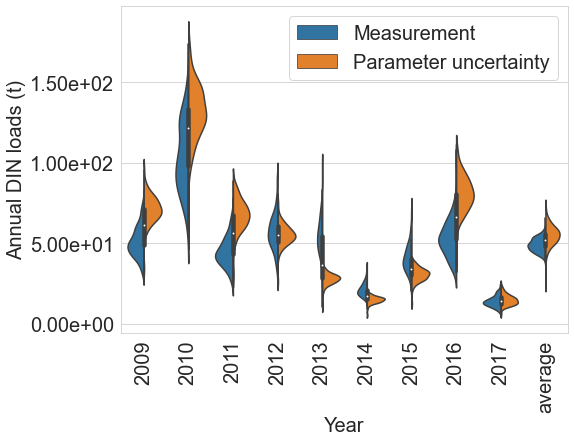

In [107]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Parameter uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'../../output/figs/parameter_uncertainty_{file_date}.png', dpi=300, format='png')

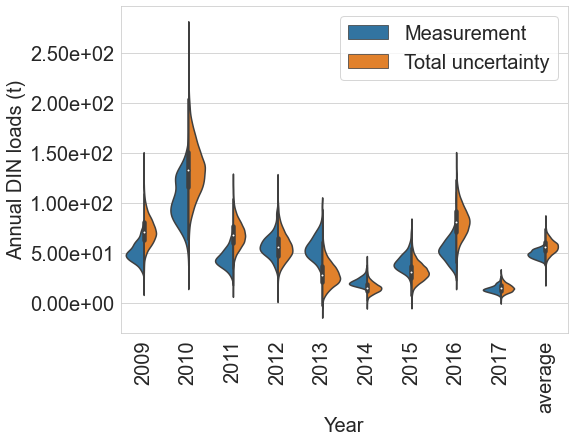

In [108]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_total_unc_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Total uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'../../output/figs/total_uncertainty_{file_date}.png', dpi=300, format='png')

## Plot metrics

In [121]:
# read files
num_pars = ['13', '12', '11', '10', '9', '7', '5', '4', '3', '1']
cols = ['Coverage ratio', 'Uncertainty overlap', 'Width index']
cols_obj = ['NSE', 'PBIAS', 'R2', 'NSE_std', 'PBIAS_std', 'R2_std', 'NSE_max', 'PBIAS_max', 'R2_max']

metric_pars_unc = pd.DataFrame(columns = cols, index=num_pars)
metric_total_unc = pd.DataFrame(columns = cols, index=num_pars)
objective_functions = pd.DataFrame()

k = 0
for fp in fpaths:
    metric_pars_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_param_unc.csv', index_col='Unnamed: 0').values
    metric_total_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_total_unc.csv', index_col='Unnamed: 0').values
    df_temp = pd.read_csv(fp +'objective_functions.csv', index_col='Unnamed: 0')
    df_temp['num_pars'] = num_pars[k]
    objective_functions = pd.concat([objective_functions, df_temp])
    
    k += 1
# cols = metric_dict[file_dates[k-1]].columns
objective_functions = objective_functions.reset_index(drop=True).reset_index()
objective_functions['PBIAS'] = objective_functions['PBIAS'].values / 100

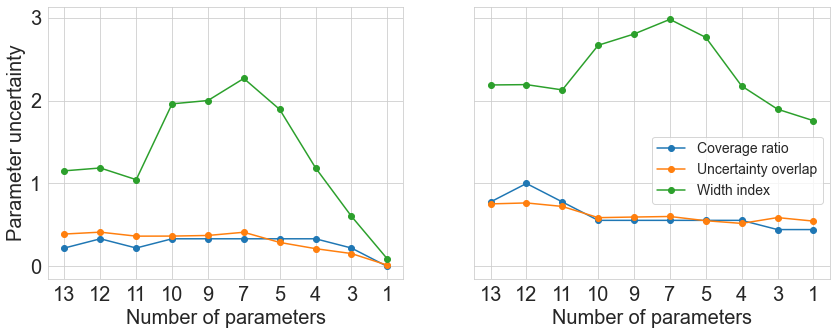

In [140]:
# plotting metrics
import matplotlib.ticker as ticker
ylabs = ['Parameter uncertainty', 'Prediction uncertainty']
fig, axes = plt.subplots(1, 2, figsize=(7*2, 5*1), sharey=True)
metric_pars_unc.plot(ax=axes[0], marker='o', legend=False)
metric_total_unc.plot(ax=axes[1], marker='o', legend=False)
for ii in range(2):
    axes[ii].set_ylabel(ylabs[ii])
    axes[ii].set_xlabel('Number of parameters')
#     axes[ii].set_xticks(np.arange(12, 0, -1))
    axes[ii].xaxis.set_major_locator(ticker.FixedLocator(np.arange(10)))
    axes[ii].set_xticklabels(num_pars)
     
plt.legend(['Coverage ratio', 'Uncertainty overlap', 'Width index'], bbox_to_anchor=(0.48, 0.25), fontsize=14)
plt.savefig('../../output/figs/metric_param_unc.png', dpi=300, format='png')

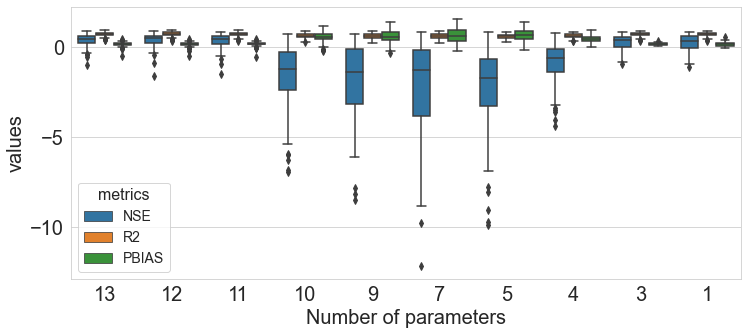

In [145]:
# Plot objective functions
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(12*1, 5*1))
df_plot = pd.DataFrame(index=np.arange(3 * objective_functions.shape[0]), columns=['values', 'num_pars', 'metrics'])
df_plot.loc[0:(objective_functions.shape[0] - 1), ['values', 'num_pars']] = objective_functions.loc[:, ['NSE', 'num_pars']].values
df_plot.loc[0:objective_functions.shape[0], 'metrics'] = 'NSE'
df_plot.loc[objective_functions.shape[0]: (2 * objective_functions.shape[0] -1), ['values', 'num_pars']] = objective_functions.loc[:, ['R2', 'num_pars']].values
df_plot.loc[objective_functions.shape[0]:(2 * objective_functions.shape[0] -1), 'metrics'] = 'R2'
df_plot.loc[2*objective_functions.shape[0]:, ['values', 'num_pars']] = objective_functions.loc[:, ['PBIAS', 'num_pars']].values
df_plot.loc[2*objective_functions.shape[0]:, 'metrics'] = 'PBIAS'
ax = sns.boxplot(data=df_plot,  x='num_pars', y='values', hue='metrics', ax=axes)
ax.set_xlabel('Number of parameters')
# sns.boxplot(data=objective_functions,  x='num_pars', y='PBIAS', ax=axes[1])
plt.savefig(f'../../output/figs/objective_functions.png', format='png', dpi=300)